In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yanhu/data/PRINT/multiScaleFootprinting/code")
import scprinter as scp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import os
import time
import torch
import pickle
from scipy.stats import *
from tqdm.auto import *
import pyBigWig
import re
from scprinter.seq.attributions import *
from scprinter.seq.attribution_wrapper import *
import random
import scipy.stats as ss
from statsmodels.stats.multitest import fdrcorrection as fdr

### Load LoRA model and input data

In [2]:
main_path = "/home/yanhu/data/PRINT/multiScaleFootprinting/data"
group_info_path = os.path.join(main_path, "mHSCAging10xMultiome", "pbulkClusters.txt")
model_dir = '/data/yanhu/PRINT/multiScaleFootprinting/data/mHSCAging10xMultiome/final_model'
peaks_path = '/data/yanhu/PRINT/multiScaleFootprinting/data/mHSCAging10xMultiome/regionRanges.bed'
models_path = {
    "Old_intermediate" : ["Old_intermediate_fold0-prosperous-peony-80.pt",
                        "Old_intermediate_fold1-floating-rabbit-82.pt",
                        "Old_intermediate_fold2-alight-cake-82.pt",
                        "Old_intermediate_fold3-glistening-snake-81.pt",
                        "Old_intermediate_fold4-crimson-fish-84.pt"],
    "Old_Mk-biased": ["Old_Mk-biased_fold0-flashing-envelope-61.pt",
    "Old_Mk-biased_fold1-enchanting-paper-62.pt",
    "Old_Mk-biased_fold2-dancing-goat-62.pt",
    "Old_Mk-biased_fold3-resplendent-paper-61.pt",
    "Old_Mk-biased_fold4-dancing-dragon-57.pt"],
    "Old_multi-lineage": ["Old_multi-lineage_fold0-twinkling-orchid-75.pt",
            "Old_multi-lineage_fold1-filigreed-rocket-76.pt",
            "Old_multi-lineage_fold2-twinkling-firecracker-77.pt",
            "Old_multi-lineage_fold3-dazzling-paper-78.pt",
            "Old_multi-lineage_fold4-enchanting-orchid-79.pt"],
    "Young_Mk-biased":["Young_Mk-biased_fold0-alight-envelope-67.pt",
        "Young_Mk-biased_fold1-prosperous-rocket-65.pt",
        "Young_Mk-biased_fold2-glistening-kumquat-68.pt",
        "Young_Mk-biased_fold3-festive-lantern-66.pt",
        "Young_Mk-biased_fold4-festive-lamp-69.pt"],
    "Young_multi-lineage":[
    "Young_multi-lineage_fold0-dancing-dumpling-72.pt",
    "Young_multi-lineage_fold1-resplendent-rocket-70.pt",
    "Young_multi-lineage_fold2-flashing-dragon-71.pt",
    "Young_multi-lineage_fold3-floating-goat-74.pt",
    "Young_multi-lineage_fold4-fortuitous-kumquat-73.pt"],
}
printer_path = '/data/yanhu/PRINT/multiScaleFootprinting/data/mHSCAging10xMultiome/scprinter.h5ad'
plot_dir = '/data/yanhu/PRINT/multiScaleFootprinting/data/mHSCAging10xMultiome/plots/diff_nucleosomes/'

In [3]:
models = {name:[torch.load(os.path.join(model_dir, m), map_location='cpu') for m in models_path[name]] for name in models_path}
for name in models:
    for m in models[name]:
        m.eval()

In [4]:
printer = scp.load_printer(printer_path, scp.genome.mm10)

Initializing GFF-db


### Motif ablation test

In [30]:
target_list = [
    ["chr12", 80112464, 80113463, 80112843, 80112854], # Yy1
    ["chr5", 124482806, 124483805, 124483343, 124483354], # Yy1
    ["chr3", 133543755, 133544754, 133544272, 133544283], # Yy1
    ["chr2", 69722367, 69723366, 69723274, 69723285], # Yy1
    ["chr6", 24664595, 24665594, 24664971, 24664982], # Yy1
    ["chr6", 88044757, 88045756, 88045384, 88045395], # Yy1
    ["chr7", 59228187, 59229186, 59228532, 59228543], # Yy1
    ["chr12", 110600852, 110601851, 110601599, 110601610], # Yy1
    ["chrX", 57392393, 57393392, 57392755, 57392766], # Yy1
    ["chr17", 36271301, 36272300, 36271658, 36271668], # Nrf1
    ["chr6", 24664595, 24665594, 24664971, 24664982], # Yy1
    ["chr6", 24664595, 24665594, 24665171, 24665181], # Same cCRE but Nrf1
    ["chr6", 24664595, 24665594, 24665097, 24665108], # Same cCRE but Stat/Ikzf1
    ["chr9", 14380585, 14381585, 14381078, 14381089], # Yy1
    ["chr7", 127273561, 127274560, 127273873, 127273884], # Yy1
    ["chr11", 72606801, 72607600, 72607125, 72607136] # Yy1
]

In [31]:
# First extract genomic DNA sequence from the target locus
# Also find the TF motif site to ablate in the target locus
example_ind = 15
chr, region_start, region_end, motif_start, motif_end = target_list[example_ind]
center = (region_start + region_end) // 2
flank = 920
seq = scp.genome.mm10.fetch_seq(chr, 
                               center-flank, 
                               center+flank)
seq_mutated = list(seq)

# Replace motif sequence with random ACGT
size = motif_end - motif_start
seq_mutated[motif_start - (center - flank): motif_end - (center - flank)] = \
    random.choices('ACGT', k=motif_end-motif_start)
p = int(random.random() * (1840-size))
    
# One-hote encode the mutated sequences
seq_mutated = ''.join(seq_mutated)
seq = scp.utils.DNA_one_hot(seq)[None].float().cuda()
seq_mutated = scp.utils.DNA_one_hot(seq_mutated)[None].float().cuda()

# Predicted footprints for mutated and wildtype sequences
pred = {}
pred_mut = {}
attrs = {}
for name in models:
    pred[name] = 0
    pred_mut[name] = 0
    attrs[name] = 0
    for m in models[name]:
        m = m.cuda()
        pred[name] += scp.utils.zscore2pval(m(seq)[0][0].detach().cpu().numpy())
        pred_mut[name] += scp.utils.zscore2pval(m(seq_mutated)[0][0].detach().cpu().numpy())
        m = m.cpu()
        wrapper = JustSumWrapper(m, res=1, threshold=0.301).cuda()
        attributions = calculate_attributions(wrapper,
                                              X=seq.cpu(),
                                              n_shuffles=20,
                                              method='shap_hypo', verbose=False)
        attrs[name] += (attributions.cpu() * seq.cpu())[0].detach().cpu().numpy()[:, 520:-520]
        wrapper = wrapper.cpu()
    pred[name] /= 5
    pred_mut[name] /= 5
    attrs[name] /= 5

2024-06-02 08:08:19 - INFO - maxp pruned
2024-06-02 08:08:19 - INFO - cmap pruned
2024-06-02 08:08:19 - INFO - kern dropped
2024-06-02 08:08:19 - INFO - post pruned
2024-06-02 08:08:19 - INFO - FFTM dropped
2024-06-02 08:08:19 - INFO - GPOS pruned
2024-06-02 08:08:19 - INFO - GSUB pruned
2024-06-02 08:08:19 - INFO - glyf pruned
2024-06-02 08:08:19 - INFO - Added gid0 to subset
2024-06-02 08:08:19 - INFO - Added first four glyphs to subset
2024-06-02 08:08:19 - INFO - Closing glyph list over 'GSUB': 30 glyphs before
2024-06-02 08:08:19 - INFO - Glyph names: ['.notdef', '.null', 'O', 'a', 'd', 'e', 'eight', 'five', 'four', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'zero']
2024-06-02 08:08:19 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 50, 66, 68, 71, 72, 76, 79, 80, 81, 82, 83, 85, 87, 88, 3228]
2024-06-02 08:08:20 - INFO - Closed glyph list o

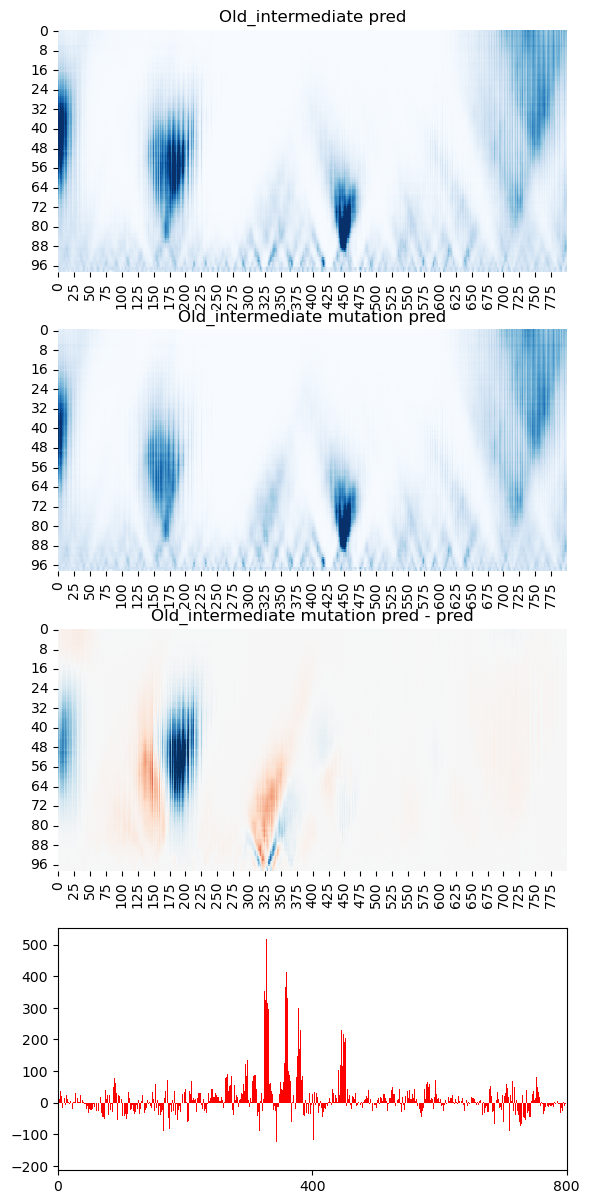

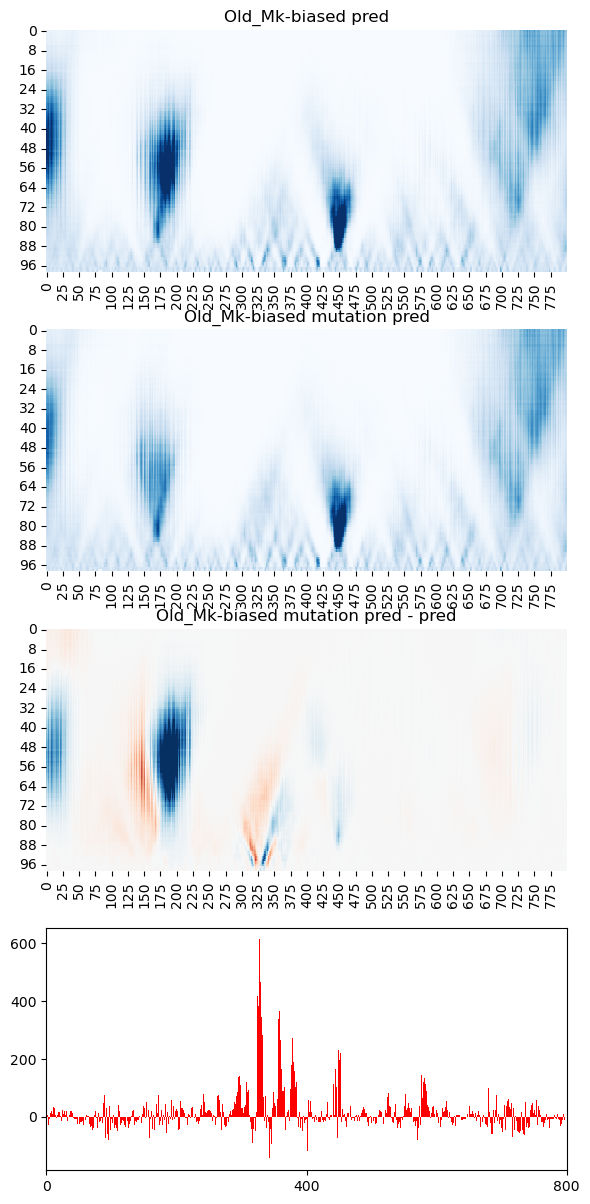

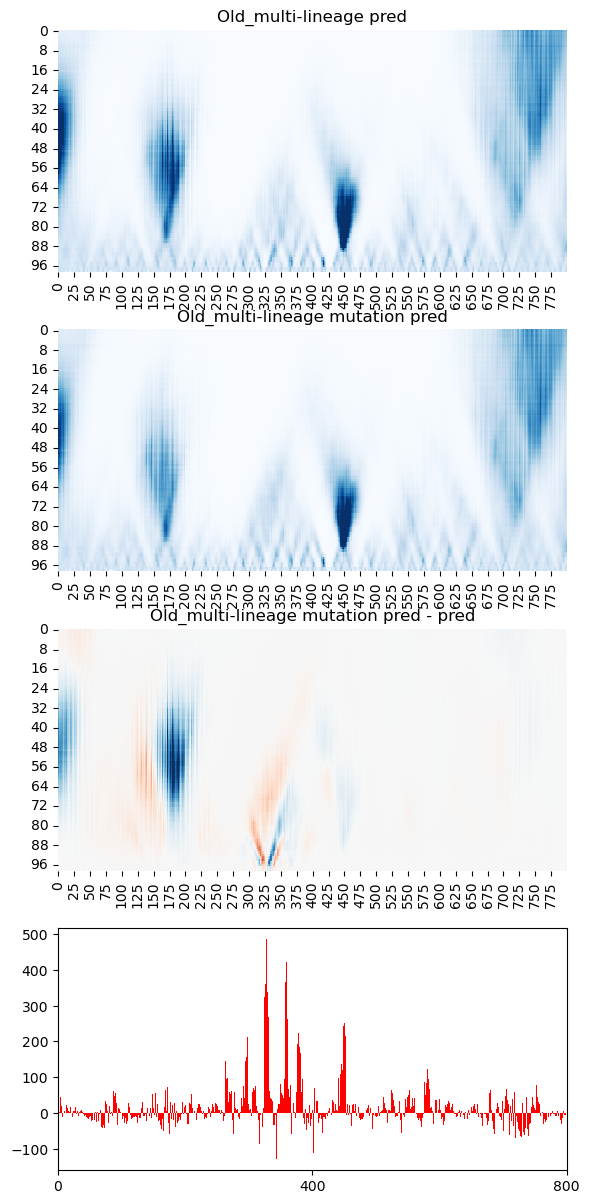

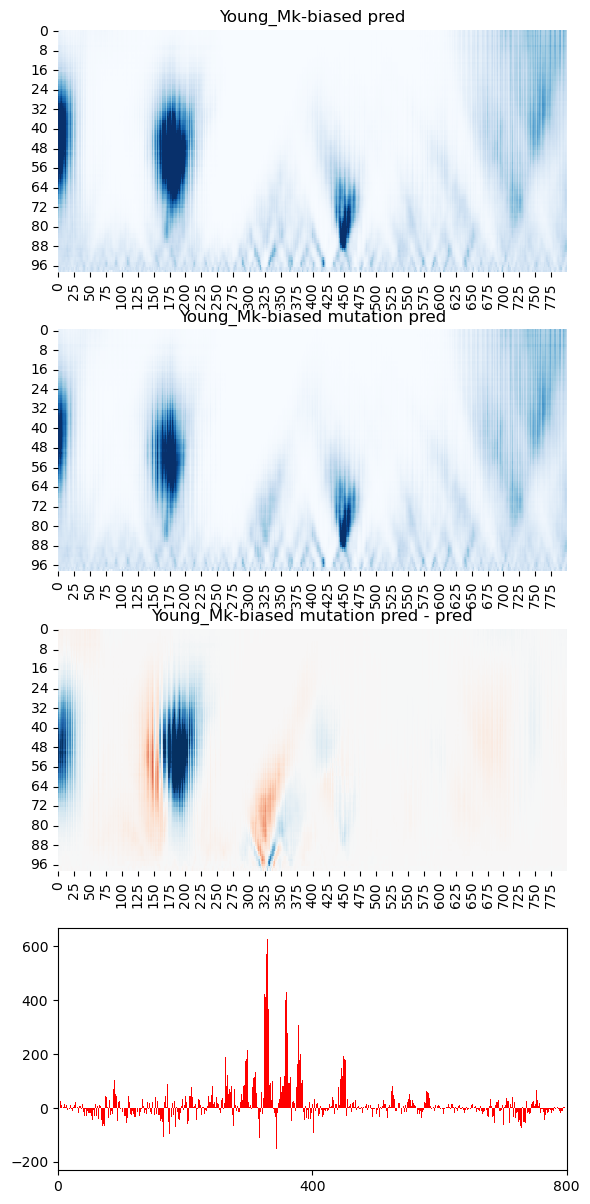

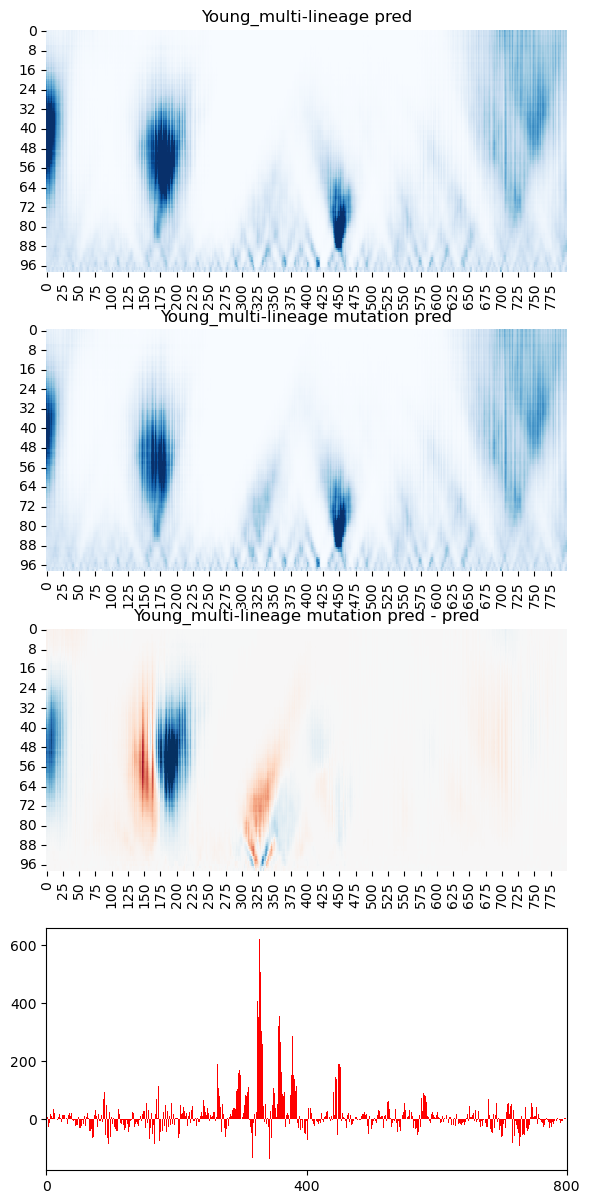

In [32]:
for name in pred:
    fig, axs = plt.subplots(4, 1, figsize=(6, 12))
    axs = list(axs)
    sns.heatmap(pred[name][::-1], cmap='Blues', ax=axs[0], vmin=0, vmax=1, cbar=False)
    sns.heatmap(pred_mut[name][::-1], cmap='Blues', ax=axs[1], vmin=0, vmax=1, cbar=False)
    sns.heatmap(pred_mut[name][::-1] - pred[name][::-1], cmap='RdBu_r', ax=axs[2], vmin=-0.5, vmax=0.5, cbar=False)
    attr = attrs[name].sum(axis=0)
    axs[3].bar(x=np.arange(len(attr)), height=attr, width=1,color='red')
    axs[3].set_xticks([0, int(0.5 * attr.shape[-1]), attr.shape[-1]])
    axs[3].set_xlim(0, attr.shape[-1])
    fig.tight_layout()
    axs[0].set_title(f'{name} pred')
    axs[1].set_title(f'{name} mutation pred')
    axs[2].set_title(f'{name} mutation pred - pred')
    plt.savefig(os.path.join(plot_dir, chr + ":" + str(region_start) + "-" + str(region_end) + \
                             "_".join(["_motif", str(motif_start), str(motif_end), name, "ablation.pdf"])))